In [317]:
"""
Created on Sun Apr 07 15:28:36 2013
@author: ashish kumar
Ghent University, Belgium
"""
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
import ipywidgets as widget
%matplotlib inline


## Fill ratio in the partially filled region without backflow and restriction

In [318]:
def freevolume_transport_zone(): # this function calucated free volume in the barrel for one pitch length
    """
    Returns:
    Vft: Free volume in a transport screw block, m3 /pitch length
    A_sx: Cross-section area of single screw
    A_bx: Cross-section area of empty barrel
    """
    # Barrel calculations
    phi_B= math.acos(CL/(2*Rb))                                                 
    A_bx = 2*(math.pi-phi_B)*Rb**2+CL*Rb*math.sin(phi_B)                        # Cross-section area of barrel, m2
    Ab_in=4*(math.pi-phi_B)*Rb*S                                                # Internal surface area of barrel section, m2

    # transport screw design calulations
    phi_S=math.acos(CL/(2*Rs)) 
    alpha_S=math.pi/nl-2*phi_S                                                      # Tip and root angle
    A_sx=nl*(phi_S*CL**2-CL*Rs*math.sin(phi_S))+0.5*nl*alpha_S*(Rs**2+(CL-Rs)**2)   # Cross-section area of a screw, m2


    # Design effect on free/unrestricted volume in barrel
    Vb_t = A_bx*S                                          # Volume of barrel section for a transport screw, m3  /pitch length
    # Vb_k = A_bx*Kd                                         # Volume of barrel section for a kneading screw, m3    
    Vs= A_sx*S                                             # Volume of screw section, m3 /pitch length
    # Vk= A_sx*Kd                                            # Volume of kneading section, m3
    Vf_t= Vb_t-2*Vs                                        # Free volume in a transport screw block, m3 /pitch length
    # Vf_k= Vb_k-2*(Vk)                                      # Free volume in a kneading screw block
    return Vf_t, A_sx, A_bx

def fill_ratio_transport_zone(mfr, rpm,rho_pow,rho_liq):
    # effect of different mass flow rate
    mfr1 = mfr/3600.                                 # powder feed rate , kg/s
    bfr  = 50.                                      # binder addition rate, g/min      % 30-70 g/min
    bfr1 = bfr/1000./3600.                          # binder addition rate, kg/s      % 30-70 g/min
    Tfr  = mfr1+bfr1                                  # total mass flow rate, kg/s            
    Qfr = bfr1/rho_liq +mfr1/rho_pow                  # Volumetric flow rate of powder bed, m3/s
    # effect of different screw speed
    Nrps = rpm/60.                              # screw turning speed, n/s        % set at 500-900 rpm            
    # fill level calculations
    Rfill_t_min = (Qfr/Nrps)*100/ Vf_t      # Fill ratio in partially filled region without backflow and restriction
    return round(Rfill_t_min,2), '%'
    

# Equipment parameters
nl = 2.                                     # number of lobes
CL = 19.34e-3                              # The distance between the screw axes, m
H  = 5e-3                                  # channel depth, m 5 mm
Rs = 12.5e-3                               # Screw radius, m 25 mmm dia
sigma= 0.37e-3                                # calander gap, m 2 mm
delta=  0.37e-3                               # flight gap, m
Rb=Rs+sigma                                   # Barrel radius, m
Rr=Rs-H                                       # Radius of the root, m
S =10.e-3                                     # pitch, m
# Kd=4.e-3                                    # Thickness of the kneading disc, m

# Material Properties
rho_pow =500.                                 # Bluk density of powder, kg/m3
rho_liq = 1100.0                              # granulation liquid bluk density, kg/m^3   1000-1200

# Process design levels
RPM = [500., 700., 900.]                         # screw speed range, rpm
MFR = [10., 17.5, 25.]                           # powder feed rate, kg/h

Vf_t, A_sx, A_bx = freevolume_transport_zone()

df = []  

for mfr in MFR:
    for rpm in RPM:
        Rfill_t_min, rx = fill_ratio_transport_zone(mfr, rpm,rho_pow,rho_liq)

        df = np.append(df,[mfr, rpm, round(Rfill_t_min,2)])

# print r'At throughput %s kg/hr and screw speed %s rpm, minimum fill ratio in partially filled region is %s %%'  % (mfr, rpm, round(Rfill_t_min,2))

df = pd.DataFrame(np.reshape(df,(len(df)/3,3)), columns=['throughput (kg/h)','screw speed (rpm)', 'Minimum fill ratio (%)'])

print df

   throughput (kg/h)  screw speed (rpm)  Minimum fill ratio (%)
0               10.0                500                   14.16
1               10.0                700                   10.12
2               10.0                900                    7.87
3               17.5                500                   24.76
4               17.5                700                   17.69
5               17.5                900                   13.76
6               25.0                500                   35.36
7               25.0                700                   25.26
8               25.0                900                   19.65


In [319]:
# Interactively calculate the Fill ratio in transportzone for different feed rate, screw speed, bulk density of powder and liquid
widget.interact(fill_ratio_transport_zone,
               mfr=(5.0,30.0,1), rpm=(300.0,1000.0,10), rho_pow=(300,800,50), rho_liq=(1000,1500,50))

(16.82, '%')

<function __main__.fill_ratio_transport_zone>

## kneading disc stagger angle effect calculations

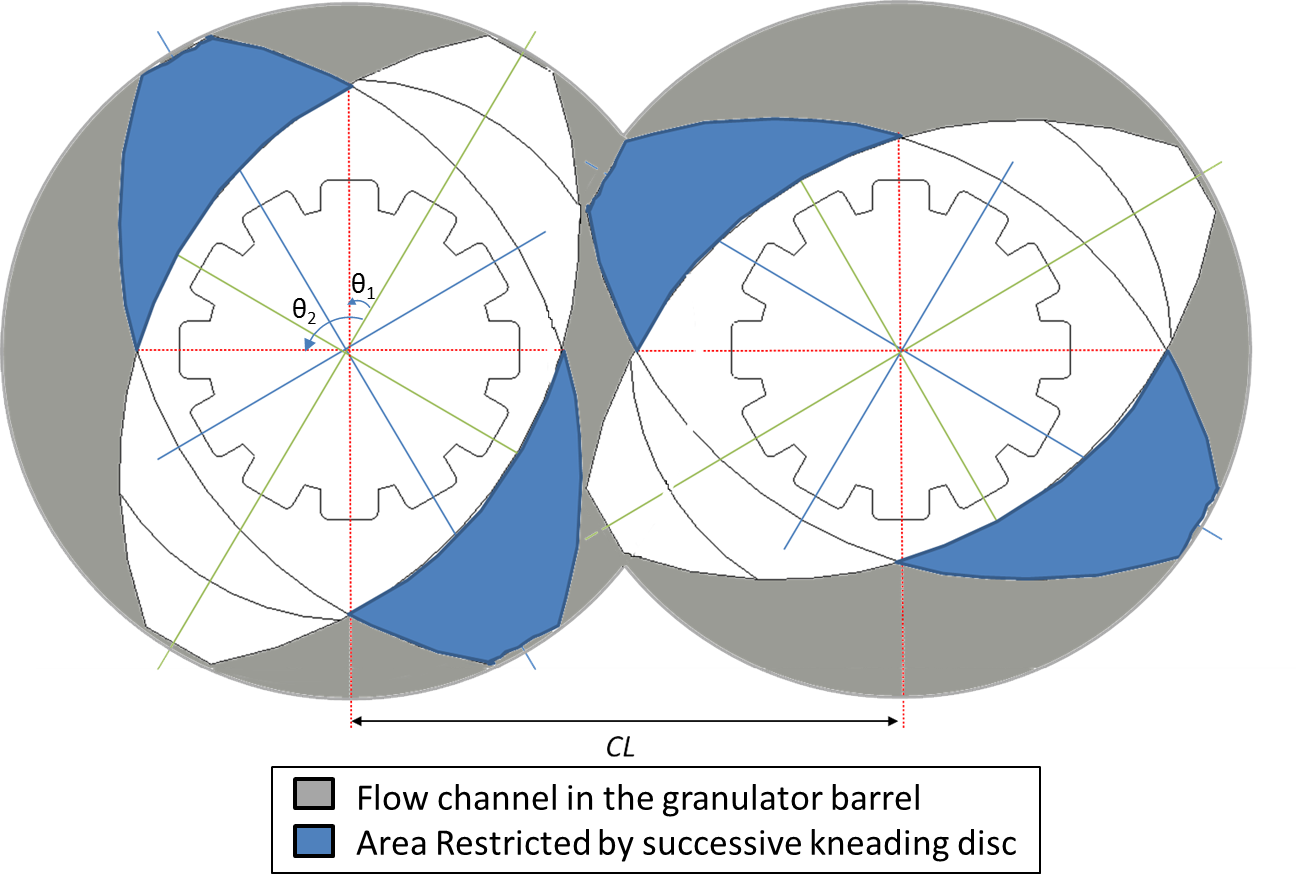

In [320]:
Image('Picture3.png', width=500)
# changing the stagger angle causes flow restriction inside the barrel.
# here we calculate how much of the channel cross-section area remains free when succesive
# kneading discs are rotated. The overall impact of staggering occurrs due to this restriction 
# by the succesive discs. This is why a large mixing zone is never successful.

In [321]:
def cf_calc(SA=0.):
    theta1 = SA/2.                                              # first angle to the elliptical sector       
    theta2 = theta1 + math.pi/2.                                # second angle to the elliptical sector  
    theta1m = math.atan((Rr/Rs)*math.tan(theta1))
    theta2m = math.atan((Rr/Rs)*math.tan(theta2))
    A_overlap = 4* (Rs/Rr)*(abs(theta1m-theta2m)/2)*(Rs/2)**2     # Area overlapped between two screw
    return A_overlap
    


def area_res_kneadingdiscs(SA):
    theta1 = SA/2                                              # first angle to the elliptical sector       
    theta2 = theta1 + math.pi/2                                # second angle to the elliptical sector  
    theta1m = math.atan((Rr/Rs)*math.tan(theta1))
    theta2m = math.atan((Rr/Rs)*math.tan(theta2))
    A_overlap = 4* (Rs/Rr)*(abs(theta1m-theta2m)/2)*(Rs/2)**2     # Uncorrected area overlapped between two screw, m2
    cf_0 = cf_calc(SA=0)-A_sx                               # calculation of correction fractor using 0° staggered disc
    A_overlap_corr = A_overlap-cf_0                         # corrected overlap area, m2
    A_res = A_sx-A_overlap_corr                             # area restricted by successive discs
    Unres_area = (1-2*A_res/(A_bx-2*A_sx)) *100                     # Unrestricted cross section after staggering  
    return A_res, Unres_area

Stagger_angle = [0, math.pi/6., math.pi/3., math.pi/2.]              # stagger angle
for SA in Stagger_angle:
    A_res, Unres_area = area_res_kneadingdiscs(SA)
    print 'Area restricted by %s° staggered disc is %.1e m^2, i.e., only %1.1f %% of area available for free-flow in barrel' \
    % (np.rad2deg(SA), A_res, Unres_area)

Area restricted by 0.0° staggered disc is 0.0e+00 m^2, i.e., only 100.0 % of area available for free-flow in barrel
Area restricted by 30.0° staggered disc is 3.4e-05 m^2, i.e., only 85.6 % of area available for free-flow in barrel
Area restricted by 60.0° staggered disc is 5.6e-05 m^2, i.e., only 76.1 % of area available for free-flow in barrel
Area restricted by 90.0° staggered disc is 6.4e-05 m^2, i.e., only 73.0 % of area available for free-flow in barrel


In [334]:
# Interactively calculate the Area restricted and free flow area ratio by the staggered disc  as a certain angle.
def area_res_kneadingdiscs1(SA):
    theta1 = SA/2                                              # first angle to the elliptical sector       
    theta2 = theta1 + math.pi/2                                # second angle to the elliptical sector  
    theta1m = math.atan((Rr/Rs)*math.tan(theta1))
    theta2m = math.atan((Rr/Rs)*math.tan(theta2))
    A_overlap = 4* (Rs/Rr)*(abs(theta1m-theta2m)/2)*(Rs/2)**2     # Uncorrected area overlapped between two screw, m2
    cf_0 = cf_calc(SA=0)-A_sx                               # calculation of correction fractor using 0° staggered disc
    A_overlap_corr = A_overlap-cf_0                         # corrected overlap area, m2
    A_res = A_sx-A_overlap_corr                             # area restricted by successive discs
    Unres_area = (1-2*A_res/(A_bx-2*A_sx)) *100                     # Unrestricted cross section after staggering  
    return round(Unres_area,2), '% of the channel area is free after staggering the kneading discs at', round(np.rad2deg(SA),1),u'°'
widget.interact(area_res_kneadingdiscs1,
               SA=(0,np.pi,np.pi/12))

(100.0,
 '% of the channel area is free after staggering the kneading discs at',
 0.0,
 u'\xb0')